# Plot mcc tree internal node probabilities over time 

I've run a 3-deme, multitype tree model in beast. I turned off migration rates from humans (so there can be no human to bird migration events) and ran 3 chains for 100,000 steps each. Honestly, the runs did not converge very well. The model REALLY wants humans to be a source population, I think because of rapid coalescence in the poultry deme. So I think from looking at the summary tree that there are quite a few inferred wild to human events, which is weird. I think from a cursory glance that we are also underestimating the circulation within the poultry deme. However, I need to actually plot out the tree and the estimates to be sure and to think about next steps for how to maybe get a more realistic picture of host switching. 

In [1]:
import glob
import re,copy, imp
import pandas as pd 
import numpy as np

# for this to work, you will need to download the most recent version of baltic, available here 
bt = imp.load_source('baltic', '/Users/lhmoncla/src/baltic/baltic/baltic.py')

%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.patheffects as path_effects
import matplotlib.lines as mlines
from matplotlib.font_manager import FontProperties
import matplotlib.colors as clr
import textwrap as textwrap
from textwrap import wrap

import rpy2
%load_ext rpy2.ipython

/var/folders/pq/2r34219j1gqfwwbv1ks0440w0000gr/T/ipykernel_75684/3388592187.py:2: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  import re,copy, imp


In [2]:
from datetime import date
current_date = str(date.today())

In [3]:
# define colors 
domestic_color="#4E83AE"
wild_color="#CEB540"
human_color="#DE4428"

In [4]:
mpl.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
mpl.rc('text', usetex='false') 
mpl.rcParams.update({'font.size': 22})

In [5]:
# tree_paths
skyline_human_off = {"label": "h5nx-GsGd-1996-Neprior", 
                     "tree": "beast-runs/2023-03-08-mascot-skyline-3deme/5-year-region-host-GsGd-only-h5nx-1996-Neprior/combined-it1-it3-2023-08-24.mcc.tree"}
# tree_paths
Ne_prior_10_year_host = {"label": "h5nx-GsGd-1996-Neprior-10-year-host", 
                     "tree": "beast-runs/2023-08-17-mascot-skyline-Ne-and-mig/h5nx-1996-to-present-10-per-year-host/10-Ne-bins-10-mig-bins/with-last-Ne-prior/combined-2023-10-09.mcc.tree"}
No_Ne_prior_10_year_host = {"label": "h5nx-GsGd-1996-10-year-host", 
                     "tree": "beast-runs/2023-08-17-mascot-skyline-Ne-and-mig/h5nx-1996-to-present-10-per-year-host/10-Ne-bins-10-mig-bins/without-last-Ne-prior/combined-noprior-2023-10-09.mcc.tree"}
Ne_prior_5_region_year_host = {"label": "h5nx-GsGd-1996-Neprior-5-region-year-host", 
                     "tree": "beast-runs/2023-08-17-mascot-skyline-Ne-and-mig/h5nx-1996-to-present-5-per-year-region-host/10-Ne-bins-10-mig-bins/with-last-Ne-prior/combined-with-prior-2023-10-09.mcc.tree"}
No_Ne_prior_5_region_year_host = {"label": "h5nx-GsGd-1996-5-region-year-host", 
                     "tree": "beast-runs/2023-08-17-mascot-skyline-Ne-and-mig/h5nx-1996-to-present-5-per-year-region-host/10-Ne-bins-10-mig-bins/without-last-Ne-prior/combined-noprior-2023-10-09.mcc.tree"}
Ne_prior_25_year_host = {"label": "h5nx-GsGd-1996-Neprior-25-year-host", 
                     "tree": "beast-runs/2023-08-17-mascot-skyline-Ne-and-mig/h5nx-1996-to-present-25-per-year-host/10-Ne-bins-10-mig-bins/with-last-Ne-prior/combined-Ne-prior-2023-10-09.mcc.tree"}

In [23]:
# read in tree
to_run = skyline_human_off

tree = bt.loadNexus(to_run['tree'])
label = to_run['label']

In [24]:
most_recent_date = 2023.1397

In [25]:
def return_node_probs_by_date(tree):
    
    node_probs = {}
    
    for k in tree.Objects: 
        if k.branchType == "node":
            host = k.traits["max"]
            host_prob = k.traits["max.prob"]
            height = k.traits["height"]
            date = most_recent_date - height
            node_probs[k] = {"host":host, "host_prob":host_prob,"date":date}
            
    return(node_probs)

In [26]:
node_probs = return_node_probs_by_date(tree)

In [27]:
df = pd.DataFrame.from_dict(node_probs, orient="index")
df.head()

,host,host_prob,date
<baltic.node object at 0x16996d420>,domestic,0.946726,1995.008941
<baltic.node object at 0x16996d360>,domestic,0.843420,1995.907522
<baltic.node object at 0x16996e140>,domestic,0.832542,1996.106714
<baltic.node object at 0x16996d330>,wild,0.834628,1999.033855
<baltic.node object at 0x16996c9a0>,wild,0.880610,1999.305524


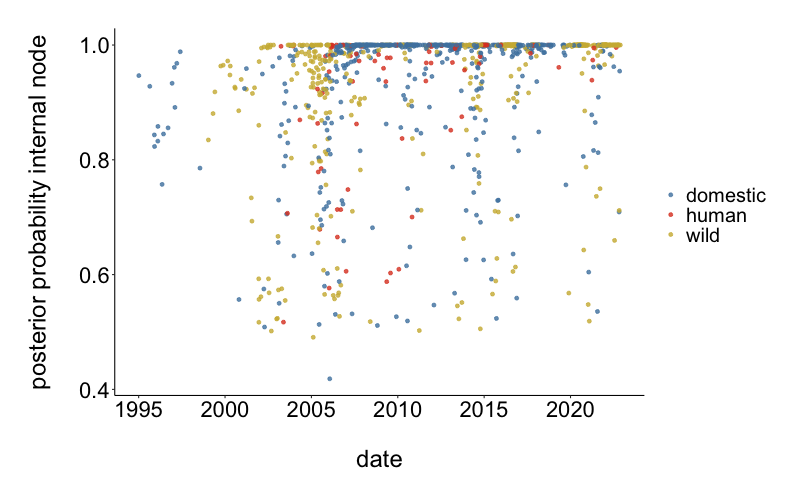

In [28]:
%%R -w 800 -h 500 -u px -i current_date,df,wild_color,domestic_color,human_color,label # this sets the size of the plot...otherwise, it will go off the page

require(ggplot2)
library(ggplot2)
library(RColorBrewer)

output_filename = paste("internal-node-probabilities-",label,"-",current_date,".pdf", sep="")

p <- ggplot(data=df, aes(x=date, y=host_prob, color=host, fill=host)) +
    geom_point(alpha=0.8)+
    labs(x="\ndate",y="posterior probability internal node\n")+
    #labs(x=paste("\nmigrations per lineage per year\n(",mig_direction,")",sep=""),y="density\n")+
     scale_color_manual(values=c(domestic=domestic_color,wild=wild_color,human=human_color))+
     scale_fill_manual(values=c(domestic=domestic_color,wild=wild_color,human=human_color))+
#     scale_y_continuous(breaks=seq(0,1,0.2), limits=c(0.8,1))+
#     scale_x_continuous(breaks=seq(0,3,1), limits=c(0,3))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+    
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title=element_text(size=24, vjust=5))+
    theme(axis.text.y=element_text(size=22, colour="black"))+
    theme(axis.text.x=element_text(size=22, colour="black", hjust=0.5))+
    theme(legend.text=element_text(size=20))+
    theme(legend.title=element_blank())+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1,1,1,1),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))
    ##theme(legend.position = c(legend_x, legend_y))

#ggsave(output_filename, width = 10, height = 6, device = "pdf", path = "figures", dpi = 300)
p

### How many internal nodes have high probabilities?

Ok, so out of 1118 internal nodes on the tree, 913 have probabilities > 0.9. I'm actually pretty happy with that. That leaves 205 internal nodes with low probabilities, or 18% of all internal nodes. 

In [29]:
print(len(df))
df_high_prob = df[df['host_prob'] >= 0.9]
print(len(df_high_prob))
df_high_prob.head()

1118
895


,host,host_prob,date
<baltic.node object at 0x16996d420>,domestic,0.946726,1995.008941
<baltic.node object at 0x16996c790>,wild,0.918367,1999.410629
<baltic.node object at 0x16996d630>,wild,0.963374,1999.751172
<baltic.node object at 0x16996ee90>,wild,0.972253,2000.155078
<baltic.node object at 0x16996d5d0>,wild,0.940067,2000.936703


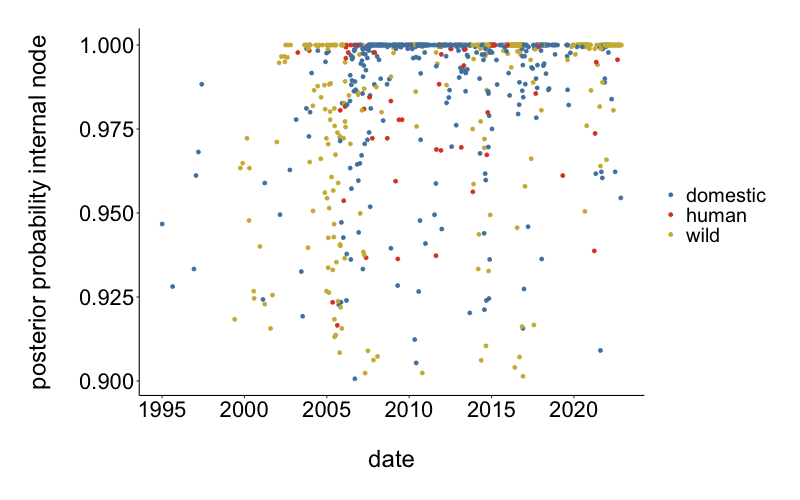

In [30]:
%%R -w 800 -h 500 -u px -i current_date,df_high_prob,wild_color,domestic_color,human_color # this sets the size of the plot...otherwise, it will go off the page

require(ggplot2)
library(ggplot2)
library(RColorBrewer)

output_filename = paste("internal-node-probabilities-over-0.9-",current_date,".pdf", sep="")

p <- ggplot(data=df_high_prob, aes(x=date, y=host_prob, color=host, fill=host)) +
    geom_point()+
    labs(x="\ndate",y="posterior probability internal node\n")+
    #labs(x=paste("\nmigrations per lineage per year\n(",mig_direction,")",sep=""),y="density\n")+
     scale_color_manual(values=c(domestic=domestic_color,wild=wild_color,human=human_color))+
     scale_fill_manual(values=c(domestic=domestic_color,wild=wild_color,human=human_color))+
#     scale_y_continuous(breaks=seq(0,1,0.2), limits=c(0.8,1))+
#     scale_x_continuous(breaks=seq(0,3,1), limits=c(0,3))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+    
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title=element_text(size=24, vjust=5))+
    theme(axis.text.y=element_text(size=22, colour="black"))+
    theme(axis.text.x=element_text(size=22, colour="black", hjust=0.5))+
    theme(legend.text=element_text(size=20))+
    theme(legend.title=element_blank())+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1,1,1,1),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))
    ##theme(legend.position = c(legend_x, legend_y))

#ggsave(output_filename, width = 10, height = 6, device = "pdf", path = "figures", dpi = 300)
p

### What fraction of high probability nodes are domestic or wild over time? 

In [31]:
df_high_prob

,host,host_prob,date
<baltic.node object at 0x16996d420>,domestic,0.946726,1995.008941
<baltic.node object at 0x16996c790>,wild,0.918367,1999.410629
<baltic.node object at 0x16996d630>,wild,0.963374,1999.751172
<baltic.node object at 0x16996ee90>,wild,0.972253,2000.155078
<baltic.node object at 0x16996d5d0>,wild,0.940067,2000.936703
...,...,...,...
<baltic.node object at 0x17362d840>,domestic,0.933333,1996.936725
<baltic.node object at 0x17362d990>,domestic,0.928108,1995.642495
<baltic.node object at 0x17362dab0>,domestic,0.961154,1997.063337
<baltic.node object at 0x17362dae0>,domestic,0.968170,1997.206762


In [32]:
proportions_df = pd.DataFrame()

for i in range(1996, 2023):
    
    local_df = df_high_prob[(df_high_prob["date"] > i)&(df_high_prob["date"] < i+1)]
    total_internal_nodes = len(local_df)
    
    if total_internal_nodes != 0:
        count_wild = len(local_df[local_df["host"]=="wild"])
        count_domestic = len(local_df[local_df["host"]=="domestic"])
        count_human = len(local_df[local_df["host"]=="human"])

        prop_wild = count_wild/total_internal_nodes
        prop_domestic = count_domestic/total_internal_nodes
        prop_human = count_human/total_internal_nodes
    
    else: 
        prop_human = 0
        prop_domestic = 0
        prop_wild = 0

    
    df2 = pd.DataFrame.from_dict({"year": i, "prop_domestic":[prop_domestic], "prop_wild":prop_wild, 
                                  "prop_human":prop_human, "total_internal_nodes":total_internal_nodes})
    proportions_df = pd.concat([proportions_df, df2])
    
proportions_df

,year,prop_domestic,prop_wild,prop_human,total_internal_nodes
0,1996,1.000000,0.000000,0.000000,1
0,1997,1.000000,0.000000,0.000000,3
0,1998,0.000000,0.000000,0.000000,0
0,1999,0.000000,1.000000,0.000000,3
0,2000,0.000000,1.000000,0.000000,6
0,2001,0.333333,0.666667,0.000000,6
0,2002,0.200000,0.800000,0.000000,10
0,2003,0.388889,0.444444,0.166667,18
0,2004,0.200000,0.800000,0.000000,20
0,2005,0.148148,0.796296,0.055556,54


In [33]:
proportions_df[proportions_df['total_internal_nodes']>=10]

,year,prop_domestic,prop_wild,prop_human,total_internal_nodes
0,2002,0.200000,0.800000,0.000000,10
0,2003,0.388889,0.444444,0.166667,18
0,2004,0.200000,0.800000,0.000000,20
0,2005,0.148148,0.796296,0.055556,54
0,2006,0.549020,0.294118,0.156863,51
0,2007,0.704918,0.180328,0.114754,61
0,2008,0.794872,0.153846,0.051282,39
0,2009,0.590909,0.272727,0.136364,44
0,2010,0.694915,0.305085,0.000000,59
0,2011,0.593750,0.187500,0.218750,32


In [34]:
proportions_df = pd.melt(proportions_df, id_vars=['year', 'total_internal_nodes'], value_vars=['prop_domestic','prop_wild','prop_human'])
proportions_df

,year,total_internal_nodes,variable,value
0,1996,1,prop_domestic,1.000000
1,1997,3,prop_domestic,1.000000
2,1998,0,prop_domestic,0.000000
3,1999,3,prop_domestic,0.000000
4,2000,6,prop_domestic,0.000000
...,...,...,...,...
76,2018,30,prop_human,0.033333
77,2019,13,prop_human,0.076923
78,2020,57,prop_human,0.000000
79,2021,41,prop_human,0.073171


### Should we only show after 2002? 

2002 is the first time in our data that we ahve all 3 demes present in the tree as tips, and also the first time we get to 10 internal nodes. 

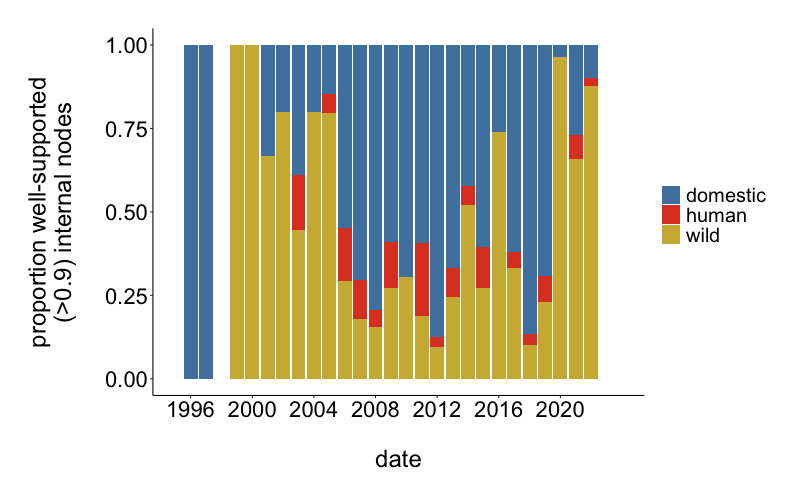

In [35]:
%%R -w 800 -h 500 -u px -i current_date,proportions_df,wild_color,domestic_color,human_color,label # this sets the size of the plot...otherwise, it will go off the page

require(ggplot2)
library(ggplot2)
library(RColorBrewer)

output_filename = paste("internal-node-probabilities-all-over-0.9-histogram-",label,"-",current_date,".pdf", sep="")

p <- ggplot(data=proportions_df, aes(x=year, y=value, fill=variable)) +
    geom_bar(stat="identity")+
    labs(x="\ndate",y="proportion well-supported\n(>0.9) internal nodes\n")+
    #labs(x=paste("\nmigrations per lineage per year\n(",mig_direction,")",sep=""),y="density\n")+
     #scale_color_manual(values=c(prop_domestic=domestic_color,prop_wild=wild_color,prop_human=human_color), labels=c(prop_domestic="domestic",prop_wild="wild",prop_human="human"))+
     scale_fill_manual(values=c(prop_domestic=domestic_color,prop_wild=wild_color,prop_human=human_color), labels=c(prop_domestic="domestic",prop_wild="wild",prop_human="human"))+
#     scale_y_continuous(breaks=seq(0,1,0.2), limits=c(0.8,1))+
    scale_x_continuous(breaks=seq(1996,2023,4), limits=c(1995,2024))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+    
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title=element_text(size=24, vjust=5))+
    theme(axis.text.y=element_text(size=22, colour="black"))+
    theme(axis.text.x=element_text(size=22, colour="black", hjust=0.5))+
    theme(legend.text=element_text(size=20))+
    theme(legend.title=element_blank())+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1,1,1,1),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))
    ##theme(legend.position = c(legend_x, legend_y))

#ggsave(output_filename, width = 12, height = 6, device = "pdf", path = "figures", dpi = 300)
p

R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: Removed 24 rows containing missing values (`position_stack()`). 

R[write to console]: 2: Removed 3 rows containing missing values (`geom_bar()`). 



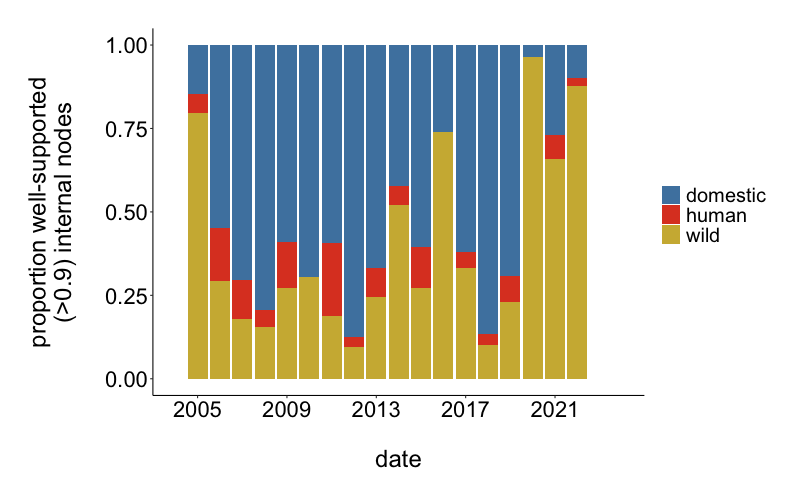

In [36]:
%%R -w 800 -h 500 -u px -i current_date,proportions_df,wild_color,domestic_color,human_color,label # this sets the size of the plot...otherwise, it will go off the page

require(ggplot2)
library(ggplot2)
library(RColorBrewer)

output_filename = paste("internal-node-probabilities-post-2005-over-0.9-histogram-",label,"-",current_date,".pdf", sep="")

p <- ggplot(data=proportions_df, aes(x=year, y=value, fill=variable)) +
    geom_bar(stat="identity")+
    labs(x="\ndate",y="proportion well-supported\n(>0.9) internal nodes\n")+
    #labs(x=paste("\nmigrations per lineage per year\n(",mig_direction,")",sep=""),y="density\n")+
     #scale_color_manual(values=c(prop_domestic=domestic_color,prop_wild=wild_color,prop_human=human_color), labels=c(prop_domestic="domestic",prop_wild="wild",prop_human="human"))+
     scale_fill_manual(values=c(prop_domestic=domestic_color,prop_wild=wild_color,prop_human=human_color), labels=c(prop_domestic="domestic",prop_wild="wild",prop_human="human"))+
#     scale_y_continuous(breaks=seq(0,1,0.2), limits=c(0.8,1))+
    scale_x_continuous(breaks=seq(2005,2023,4), limits=c(2004,2024))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+    
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title=element_text(size=24, vjust=5))+
    theme(axis.text.y=element_text(size=22, colour="black"))+
    theme(axis.text.x=element_text(size=22, colour="black", hjust=0.5))+
    theme(legend.text=element_text(size=20))+
    theme(legend.title=element_blank())+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1,1,1,1),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))
    ##theme(legend.position = c(legend_x, legend_y))

#ggsave(output_filename, width = 12, height = 6, device = "pdf", path = "figures", dpi = 300)
p